In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Define the path to the uploaded file
file_path = '/content/drive/MyDrive/WVUResearch/updated_data.csv'
df = pd.read_csv(file_path)
df

,Year,SubRecipientCode,City,State,Mode,Basic Information - Subrecipient Reporter Type,Total Operating Expense,Total Active Revenue Vehicles,Annual Vehicle Revenue Miles,Total Unlinked Passenger Trips,Region
0,2018,0R01-00311,Ketchum,ID,All,Rural Reporter,2722290.0,35.0,851065.0,536583.0,Mountain
1,2018,0R01-00341,Ponderay,ID,All,Rural Reporter,516231.0,8.0,167051.0,69822.0,Mountain
2,2018,0R01-00347,Lewiston,ID,All,Rural Reporter,590539.0,10.0,84099.0,161322.0,Mountain
3,2018,0R01-00357,Twin Falls,ID,All,Rural Reporter,545266.0,12.0,87298.0,19938.0,Mountain
4,2018,0R01-00403,Salmon,ID,All,Rural Reporter,156627.0,4.0,32097.0,16747.0,Mountain
...,...,...,...,...,...,...,...,...,...,...,...
5270,2022,9R04-91107,Laughlin,NV,All,Rural Reporter,1115748.0,15.0,241989.0,77434.0,Mountain
5271,2022,9R04-91113,Yerington,NV,All,Rural Reporter,192122.0,12.0,56906.0,5177.0,Mountain
5272,2022,9R04-99430,Pahrump,NV,All,Rural Reporter,566863.0,13.0,258508.0,30292.0,Mountain
5273,2022,9R05-90999,Upper Tumon,GU,All,Rural Reporter,2026980.0,29.0,445097.0,24554.0,Pacific


### Panel DEA Analysis

•    Input-Oriented DEA: This approach was correctly implemented in the provided code, focusing on reducing inputs while maintaining outputs constant.

•    Panel Data Analysis: The code loops through each agency across different time periods (years) to calculate efficiency scores, aligning with panel data methodology.

In [4]:
import pandas as pd
import cvxpy as cp
import numpy as np
def panel_dea_analysis(df, inputs_columns, outputs_columns):
    # Extract unique agencies and years
    agencies = df['SubRecipientCode'].unique()
    years = df['Year'].unique()

    # Prepare a dataframe to store results
    results = pd.DataFrame(columns=['SubRecipientCode', 'Year', 'Efficiency Score', 'State', 'Region'])

    # Loop over each agency
    for agency in agencies:
        # Filter data for the current agency across all years
        agency_data = df[df['SubRecipientCode'] == agency]
        if agency_data.shape[0] == len(years):  # Ensure the agency has data for all years
            # Prepare the input and output data
            inputs = agency_data[inputs_columns].values
            outputs = agency_data[outputs_columns].values
            n_dmus = inputs.shape[0]  # Number of time periods

            # Array to store efficiency scores for this agency
            efficiency_scores = np.zeros(n_dmus)

            # DEA optimization for each period (time-based analysis)
            for i in range(n_dmus):
                # Define the efficiency variable
                theta = cp.Variable()

                # Define the lambda variables for the weights
                lambdas = cp.Variable(n_dmus, nonneg=True)

                # Constraints
                constraints = [
                    outputs.T @ lambdas >= outputs[i, :],  # Output constraints
                    inputs.T @ lambdas <= theta * inputs[i, :],  # Input constraints
                    cp.sum(lambdas) == 1  # RTS (Returns to Scale) assumption
                ]

                # Objective function: Minimize theta (input-oriented DEA)
                objective = cp.Minimize(theta)

                # Solve the DEA problem
                problem = cp.Problem(objective, constraints)
                problem.solve()

                # Store the efficiency score
                efficiency_scores[i] = theta.value

            # Append results to the results DataFrame
            agency_results = pd.DataFrame({
                'SubRecipientCode': agency,
                'Year': agency_data['Year'],
                'Efficiency Score': efficiency_scores,
                'State': agency_data['State'].values,  # Include State column
                'Region': agency_data['Region'].values  # Include Region column
            })
            results = pd.concat([results, agency_results], ignore_index=True)

    return results

# Define the input and output columns
inputs_columns = ['Total Operating Expense', 'Total Active Revenue Vehicles']
outputs_columns = ['Annual Vehicle Revenue Miles', 'Total Unlinked Passenger Trips']

# Apply Panel DEA for all agencies across all years
panel_dea_results = panel_dea_analysis(df, inputs_columns, outputs_columns)

# Sorting and viewing the results
panel_dea_results_sorted = panel_dea_results.sort_values(by=['SubRecipientCode', 'Year'])

# Check and cap efficiency scores
panel_dea_results_sorted['Efficiency Score'] = panel_dea_results_sorted['Efficiency Score'].clip(upper=1.00000)

# Display the adjusted results
panel_dea_results_sorted

<ipython-input-4-0bbc424fcfd7>:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, agency_results], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,SubRecipientCode,Year,Efficiency Score,State,Region
0,0R01-00311,2018,1.000000,ID,Mountain
1,0R01-00311,2019,1.000000,ID,Mountain
2,0R01-00311,2020,0.919361,ID,Mountain
3,0R01-00311,2021,0.845443,ID,Mountain
4,0R01-00311,2022,1.000000,ID,Mountain
...,...,...,...,...,...
5270,9R06-99434,2018,1.000000,AS,Pacific
5271,9R06-99434,2019,1.000000,AS,Pacific
5272,9R06-99434,2020,1.000000,AS,Pacific
5273,9R06-99434,2021,0.957792,AS,Pacific


In [5]:
import matplotlib.pyplot as plt

# Group by Year and calculate summary statistics for Efficiency Score
yearly_summary = panel_dea_results.groupby('Year')['Efficiency Score'].agg(['mean', 'median', 'min', 'max'])

yearly_summary


,mean,median,min,max
Year,,,,
2018,0.998780,1.0,0.843119,1.000000
2019,0.993384,1.0,0.705882,1.000000
2020,0.971601,1.0,0.640602,1.003760
2021,0.960583,1.0,0.508222,1.010727
2022,0.967416,1.0,0.512027,1.063309


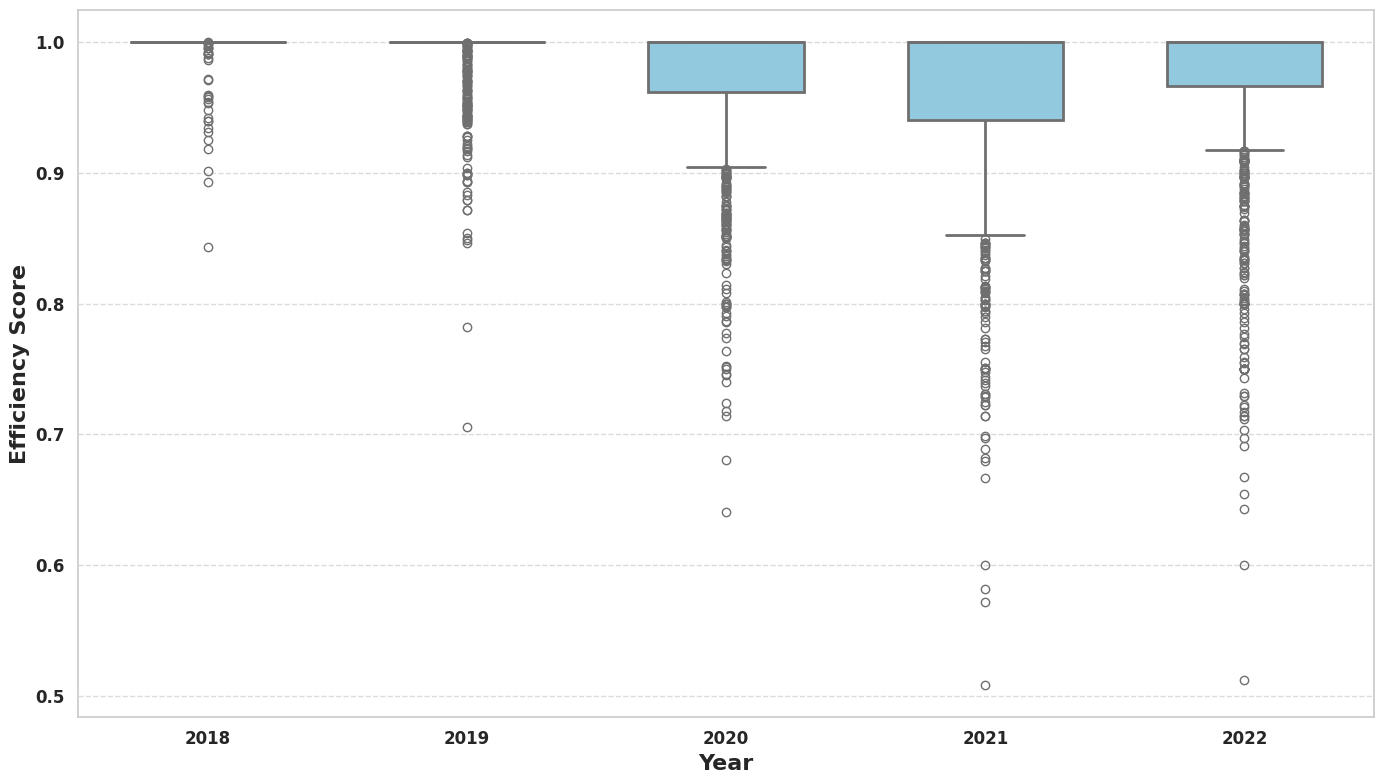

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting a better style and palette for the plot
sns.set(style="whitegrid", palette="muted")

# Box plot to visualize efficiency scores distribution by year
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='Year',
    y='Efficiency Score',
    data=panel_dea_results_sorted,
    color='skyblue',
    width=0.6,
    fliersize=6,
    linewidth=2
)

# Add a descriptive title for the figure
# plt.title('Yearly Distribution of DEA Efficiency Scores', fontsize=18, fontweight='bold')

# Make axis labels and ticks bold and larger for readability
plt.xlabel('Year', fontsize=16, fontweight='bold')  # Set x-axis label to bold
plt.ylabel('Efficiency Score', fontsize=16, fontweight='bold')  # Set y-axis label to bold
plt.xticks(fontsize=12, fontweight='bold')  # Bold the x-ticks (Years)
plt.yticks(fontsize=12, fontweight='bold')  # Bold the y-ticks

# Add a grid for the y-axis to improve visibility of the distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plot
plt.show()


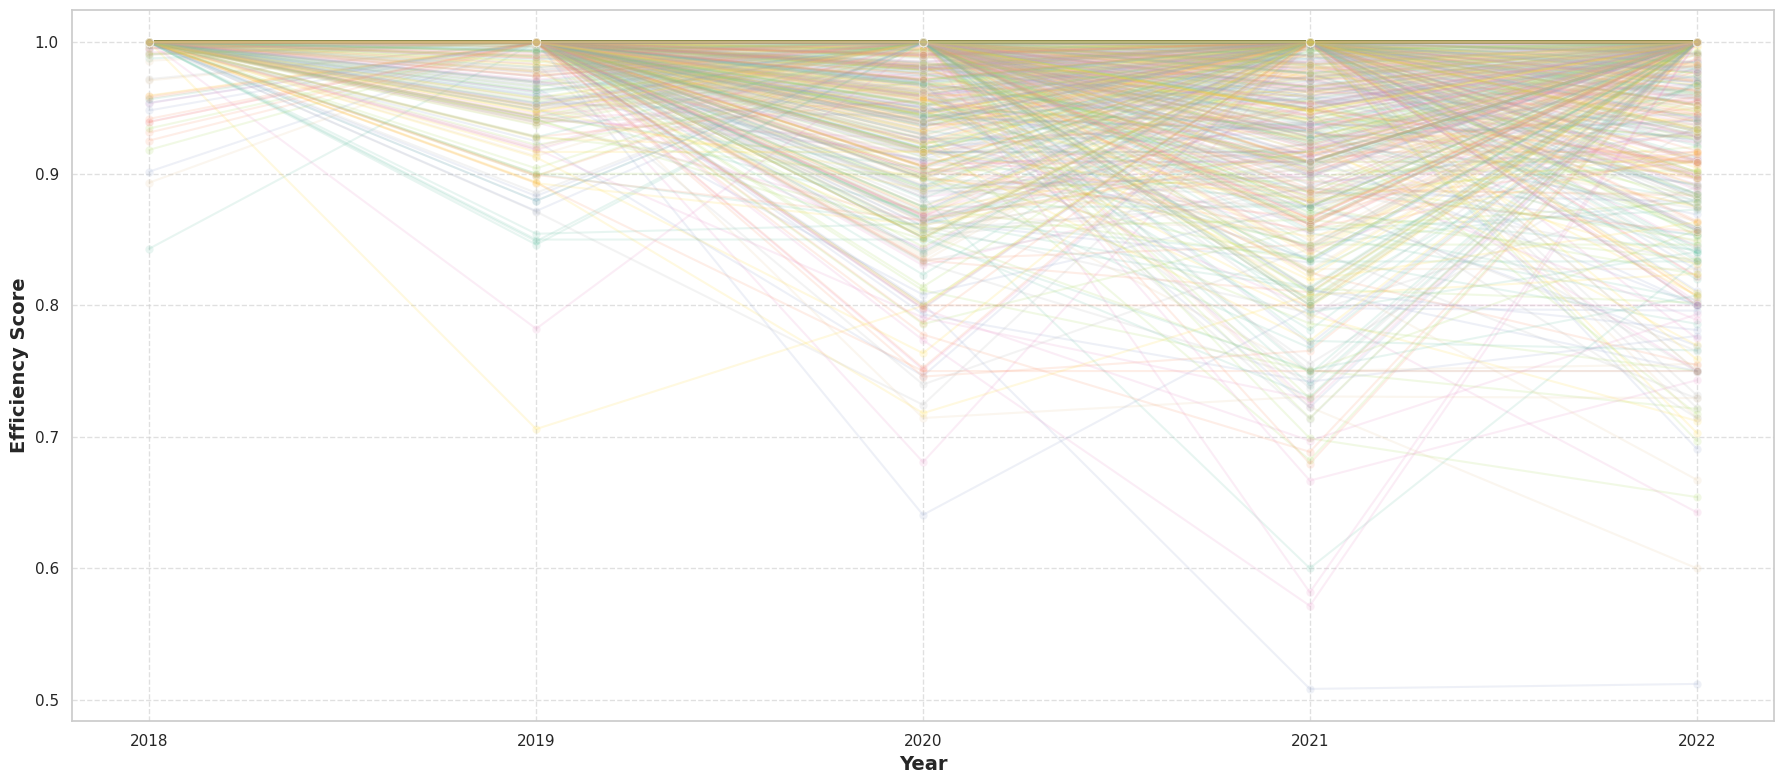

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Line Plot for Agency Performance Over 5 Years with reduced alpha and color palette
plt.figure(figsize=(18, 8))
sns.lineplot(data=panel_dea_results_sorted, x='Year', y='Efficiency Score', hue='SubRecipientCode',
             marker='o', legend=None, alpha=0.15, palette='Set2')

# Add title and axis labels with bold formatting
# plt.title('Efficiency Score Trends of 1055 Agencies Over 5 Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Efficiency Score', fontsize=14, fontweight='bold')

# Customize grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-ticks to display years
plt.xticks([2018, 2019, 2020, 2021, 2022])

# Adjust layout to fit all elements
plt.tight_layout()

# Show the updated plot
plt.show()


               Region  Agencies
0  East North Central       214
1  East South Central        64
2     Middle Atlantic        51
3            Mountain       123
4         New England        26
5             Pacific       114
6      South Atlantic       165
7  West North Central       213
8  West South Central        85


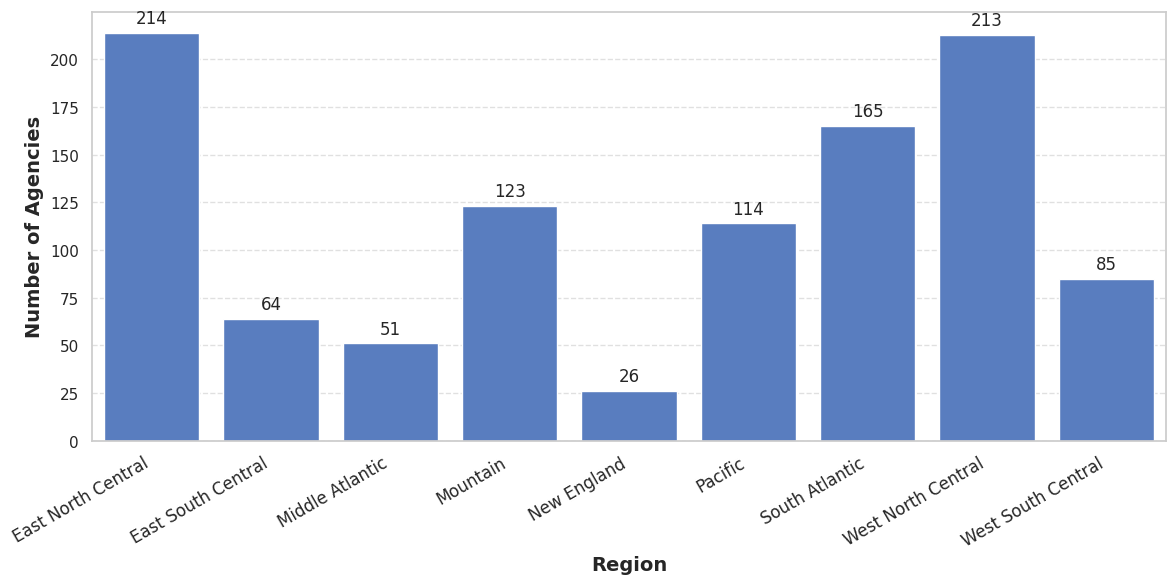

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated regional classification of states
regions = {
    'New England': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'Middle Atlantic': ['NJ', 'NY', 'PA'],
    'East North Central': ['IL', 'IN', 'MI', 'OH', 'WI'],
    'West North Central': ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South Atlantic': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'DC'],
    'East South Central': ['AL', 'KY', 'MS', 'TN'],
    'West South Central': ['AR', 'LA', 'OK', 'TX'],
    'Mountain': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY'],
    'Pacific': ['AK', 'CA', 'HI', 'OR', 'WA', 'GU', 'AS', 'PR']
}

# Your state data (the number of agencies in each state are stored in this dictionary)
state_data = pd.Series({
    'AK': 10, 'AL': 20, 'AR': 8, 'AS': 1, 'AZ': 13, 'CA': 48, 'CO': 29, 'CT': 2,
    'FL': 18, 'GA': 58, 'GU': 1, 'HI': 2, 'IA': 19, 'ID': 6, 'IL': 38, 'IN': 38,
    'KS': 72, 'KY': 20, 'LA': 31, 'MA': 3, 'MD': 5, 'ME': 9, 'MI': 60, 'MN': 25,
    'MO': 20, 'MS': 16, 'MT': 31, 'NC': 53, 'ND': 21, 'NE': 45, 'NH': 5, 'NJ': 4,
    'NM': 13, 'NV': 12, 'NY': 38, 'OH': 33, 'OK': 20, 'OR': 24, 'PA': 9, 'PR': 4,
    'SC': 8, 'SD': 11, 'TN': 8, 'TX': 26, 'UT': 3, 'VA': 14, 'VT': 7, 'WA': 24,
    'WI': 45, 'WV': 9, 'WY': 16
})

# Function to map states to regions
def map_state_to_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Unknown'

# Apply the function to map states to regions
state_data = state_data.reset_index()
state_data.columns = ['State', 'Agencies']
state_data['Region'] = state_data['State'].apply(map_state_to_region)

# Group by region and sum the number of agencies
region_agency_counts = state_data.groupby('Region')['Agencies'].sum().reset_index()

# Display the grouped data
print(region_agency_counts)

# Plotting the data with region-wise agency counts
plt.figure(figsize=(12, 6))
sns.barplot(data=region_agency_counts, x='Region', y='Agencies')
# plt.title('Number of Agencies by Region', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=14, fontweight='bold')
plt.ylabel('Number of Agencies', fontsize=14, fontweight='bold')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right', fontsize=12)

for index, value in enumerate(region_agency_counts['Agencies']):
    plt.text(index, value + 5, str(value), ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


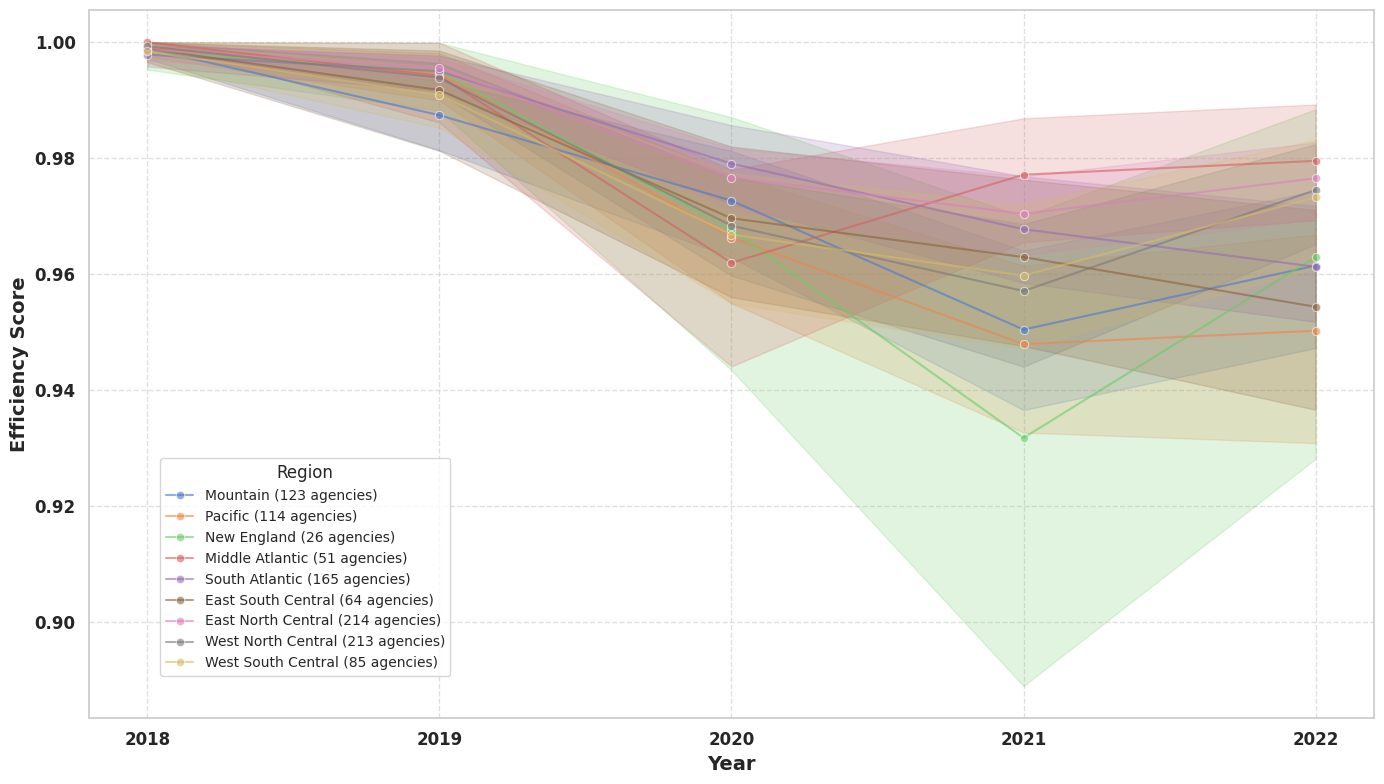

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting efficiency trends by region with agency counts
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=panel_dea_results_sorted,
    x='Year',
    y='Efficiency Score',
    hue='Region',
    marker='o',
    alpha=0.6
)

# Adjust axis labels and make them bold
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Efficiency Score', fontsize=14, fontweight='bold')

# Bold the axis ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add grid for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Relocate legend inside the plot
plt.legend(
    title='Region',
    loc='lower left',  # Position the legend within the plot
    bbox_to_anchor=(0.05, 0.05),  # Adjust its location to avoid overlap
    fontsize=10,  # Font size for legend items
    title_fontsize=12  # Font size for the legend title
)
# Set x-ticks to display years
plt.xticks([2018, 2019, 2020, 2021, 2022])
# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

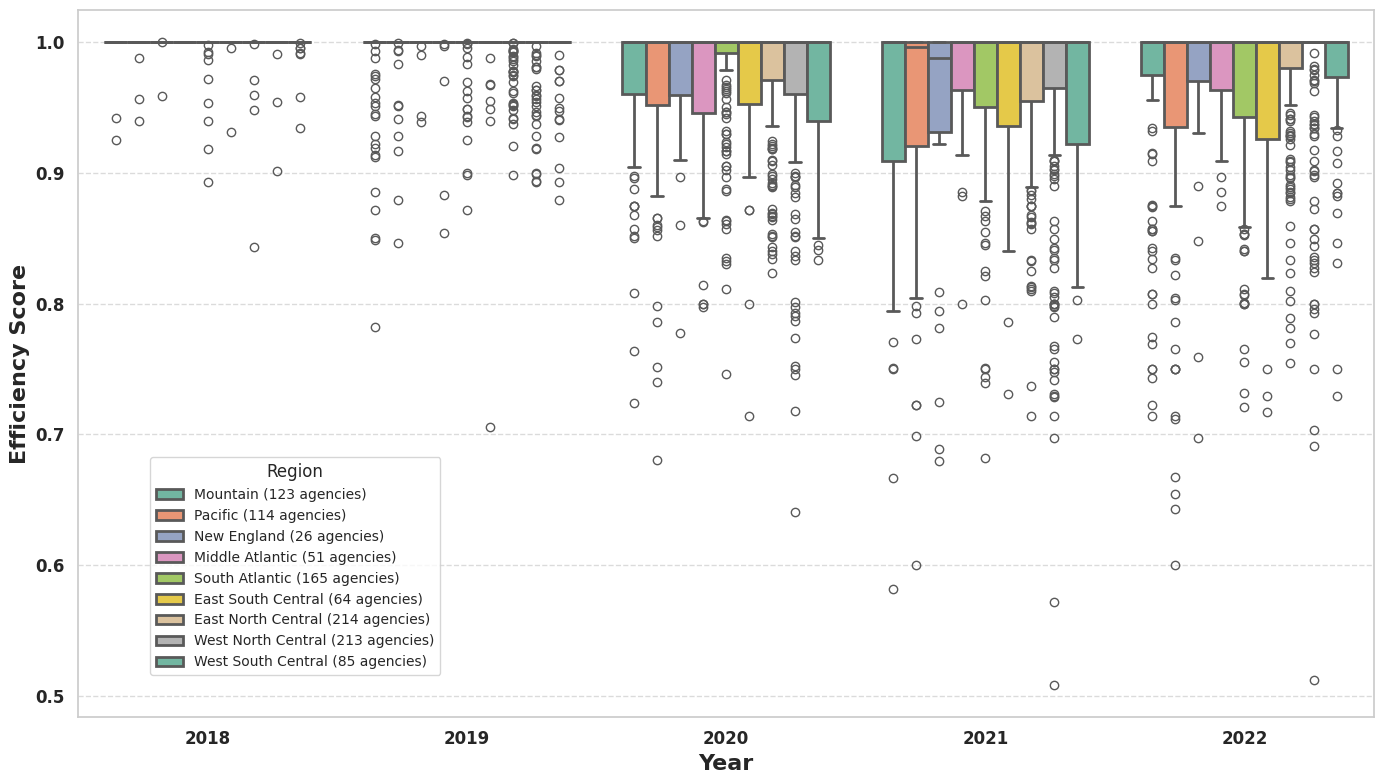

In [18]:
# Plotting with bold numbers on axes
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='Year',
    y='Efficiency Score',
    hue='Region',
    data=panel_dea_results_sorted,
    palette='Set2',
    fliersize=6,
    linewidth=2
)

# Axis labels and bold numbers
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Efficiency Score', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')  # Bold x-tick labels
plt.yticks(fontsize=12, fontweight='bold')  # Bold y-tick labels

# Gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend adjustments
plt.legend(title='Region', title_fontsize=12, fontsize=10, loc='lower left', bbox_to_anchor=(0.05, 0.05))

# Tight layout for better spacing
plt.tight_layout()

plt.show()

In [23]:
panel_dea_results_sorted

,SubRecipientCode,Year,Efficiency Score,State,Region
0,0R01-00311,2018,1.000000,ID,Mountain (123 agencies)
1,0R01-00311,2019,1.000000,ID,Mountain (123 agencies)
2,0R01-00311,2020,0.919361,ID,Mountain (123 agencies)
3,0R01-00311,2021,0.845443,ID,Mountain (123 agencies)
4,0R01-00311,2022,1.000000,ID,Mountain (123 agencies)
...,...,...,...,...,...
5270,9R06-99434,2018,1.000000,AS,Pacific (114 agencies)
5271,9R06-99434,2019,1.000000,AS,Pacific (114 agencies)
5272,9R06-99434,2020,1.000000,AS,Pacific (114 agencies)
5273,9R06-99434,2021,0.957792,AS,Pacific (114 agencies)


In [24]:
print(panel_dea_results_sorted['Region'].unique())

['Mountain (123 agencies)' 'Pacific (114 agencies)'
 'New England (26 agencies)' 'Middle Atlantic (51 agencies)'
 'South Atlantic (165 agencies)' 'East South Central (64 agencies)'
 'East North Central (214 agencies)' 'West North Central (213 agencies)'
 'West South Central (85 agencies)']


In [25]:
import re

# Clean the Region column by removing text in parentheses and any trailing/leading spaces
panel_dea_results_sorted['Region'] = panel_dea_results_sorted['Region'].apply(lambda x: re.sub(r"\s*\(.*\)", "", x).strip())

# Verify the unique values after cleaning
print(panel_dea_results_sorted['Region'].unique())

['Mountain' 'Pacific' 'New England' 'Middle Atlantic' 'South Atlantic'
 'East South Central' 'East North Central' 'West North Central'
 'West South Central']


### **Forecasting Future Efficiency Trends**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


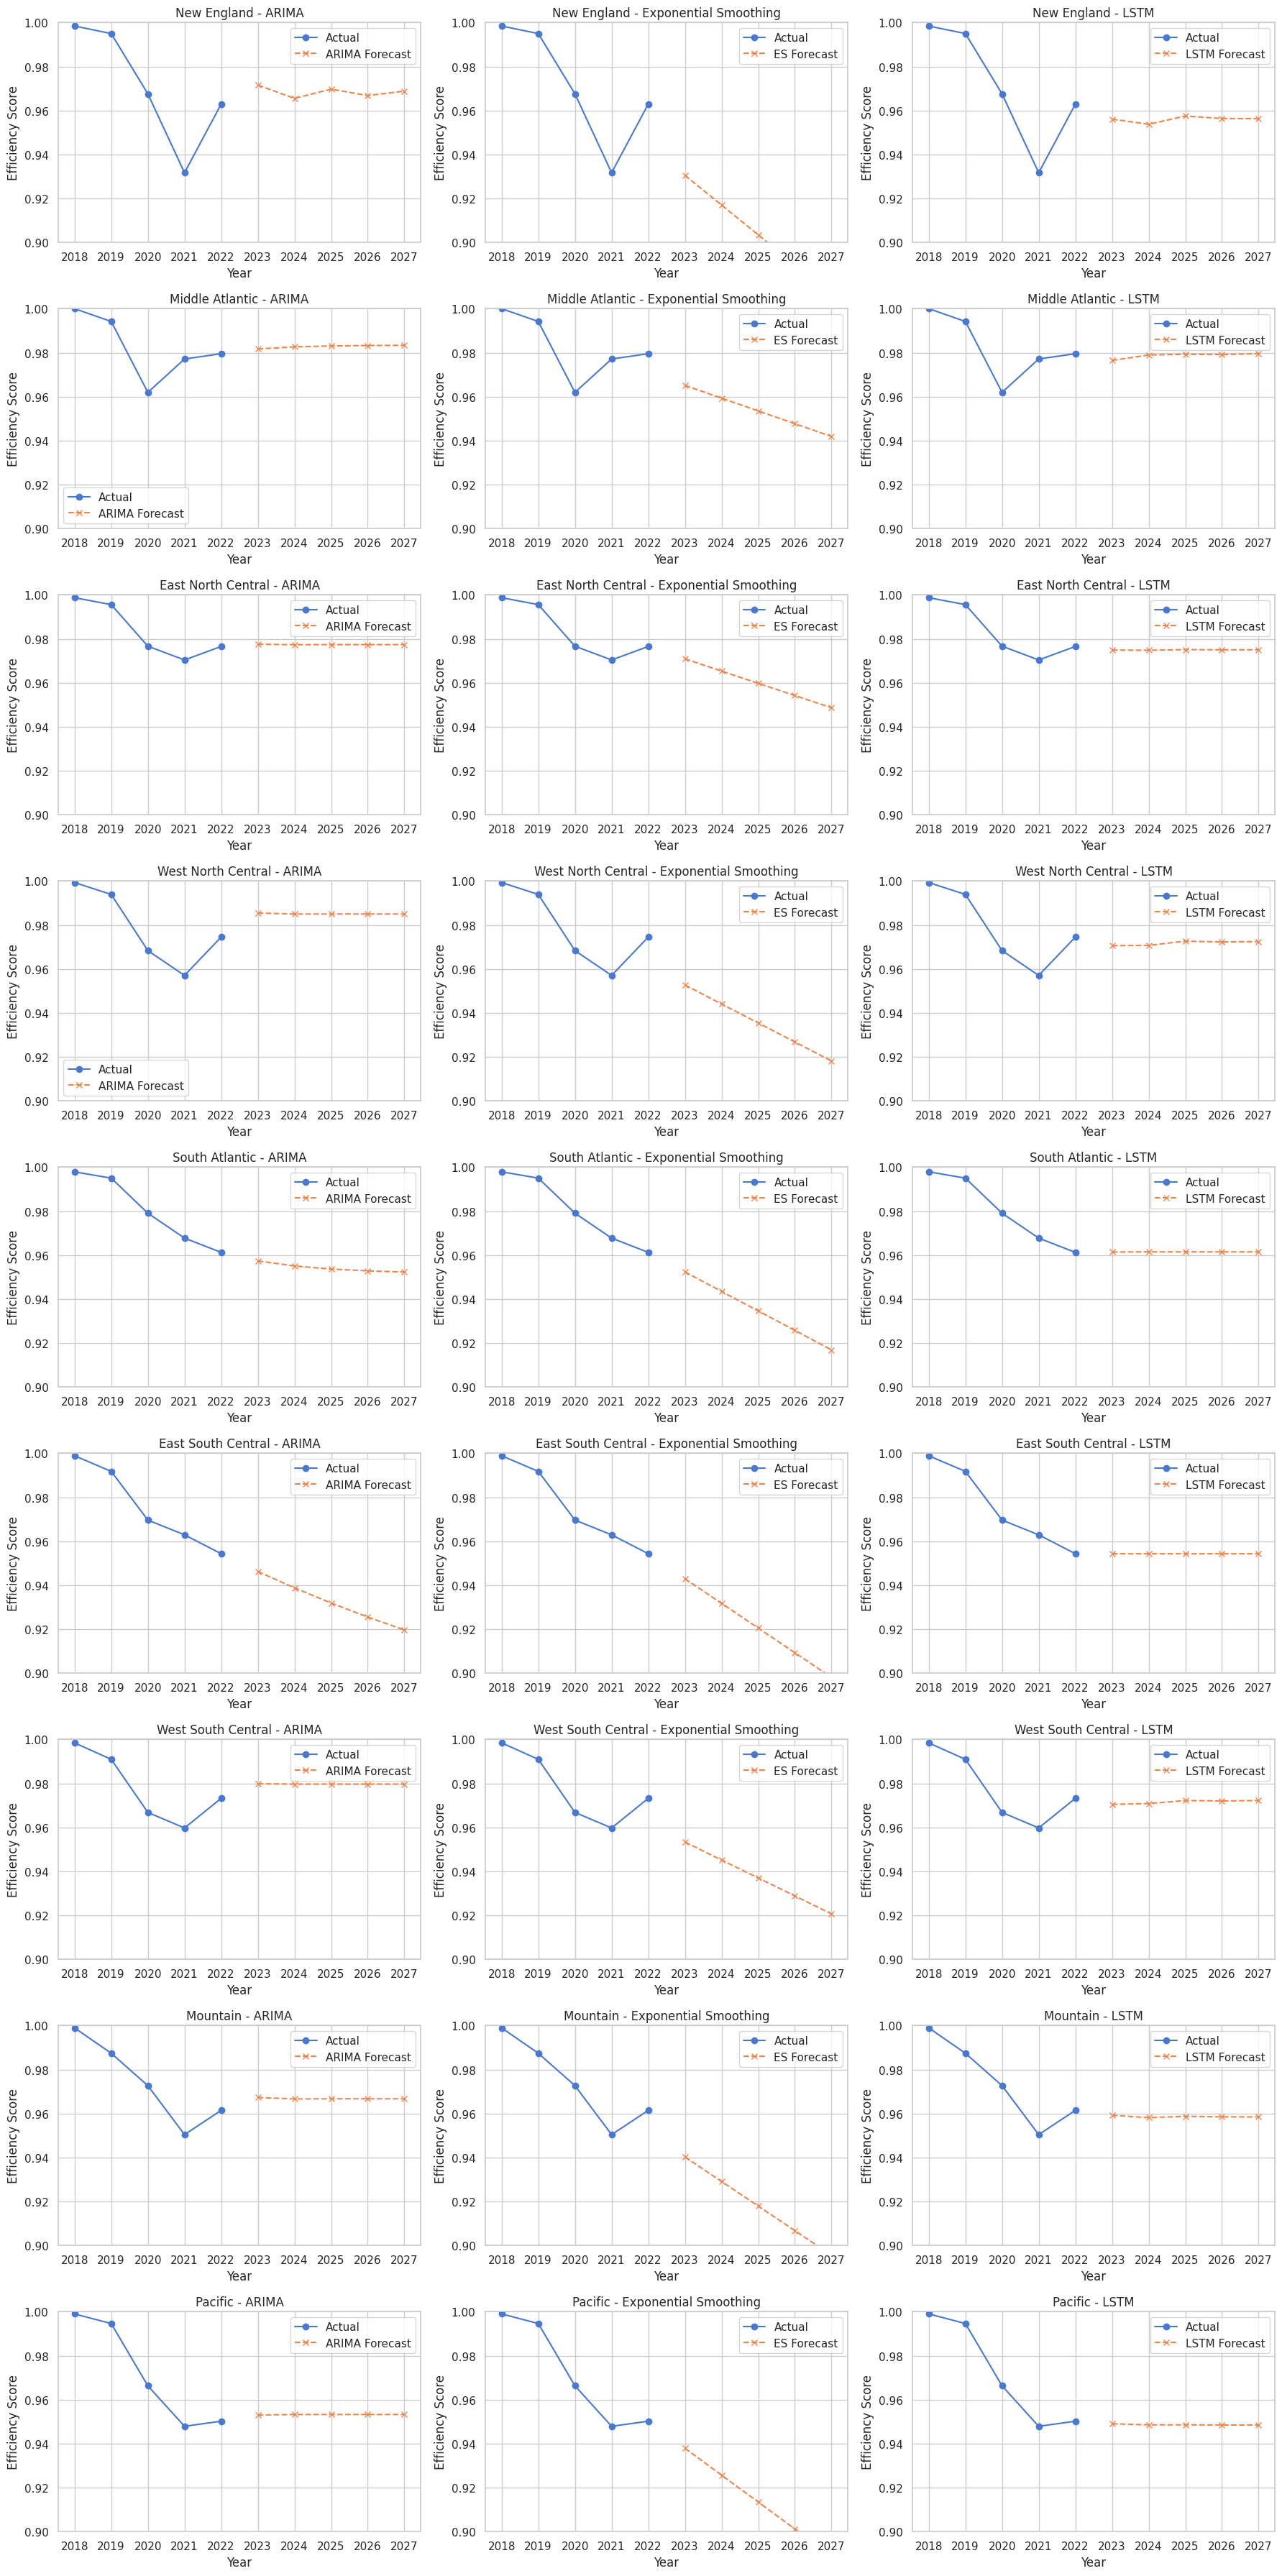

In [26]:
plt.figure(figsize=(18, 36))

for row, region in enumerate(regions, 1):
    # Filter data for the specific region
    region_data = panel_dea_results_sorted[panel_dea_results_sorted['Region'] == region]
    region_avg = region_data.groupby('Year')['Efficiency Score'].mean()
    region_avg.index = region_avg.index.astype(int)

    # Skip regions with insufficient data
    if region_avg.empty or len(region_avg) < 3:
        print(f"Skipping region {region} due to insufficient data.")
        continue

    # ARIMA Forecasting
    try:
        model_arima = ARIMA(region_avg, order=(1, 1, 1)).fit()
        forecast_arima = model_arima.forecast(5)
        forecast_arima.index = forecast_years
        plt.subplot(len(regions), 3, row * 3 - 2)
        plt.plot(region_avg.index, region_avg, marker='o', label='Actual')
        plt.plot(forecast_arima.index, forecast_arima, marker='x', linestyle='--', label='ARIMA Forecast')
        plt.xticks(list(region_avg.index) + list(forecast_years))
        plt.title(f'{region} - ARIMA')
        plt.xlabel('Year')
        plt.ylabel('Efficiency Score')
        plt.ylim(0.9, 1)
        plt.legend()
        plt.grid(True)
    except Exception as e:
        print(f"ARIMA failed for region {region}: {e}")

    # Exponential Smoothing Forecasting
    try:
        model_es = ExponentialSmoothing(region_avg, trend='add', seasonal=None).fit()
        forecast_es = model_es.forecast(5)
        forecast_es.index = forecast_years
        plt.subplot(len(regions), 3, row * 3 - 1)
        plt.plot(region_avg.index, region_avg, marker='o', label='Actual')
        plt.plot(forecast_es.index, forecast_es, marker='x', linestyle='--', label='ES Forecast')
        plt.xticks(list(region_avg.index) + list(forecast_years))
        plt.title(f'{region} - Exponential Smoothing')
        plt.xlabel('Year')
        plt.ylabel('Efficiency Score')
        plt.ylim(0.9, 1)
        plt.legend()
        plt.grid(True)
    except Exception as e:
        print(f"Exponential Smoothing failed for region {region}: {e}")

    # LSTM Forecasting
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        region_avg_scaled = scaler.fit_transform(region_avg.values.reshape(-1, 1))
        model_lstm = Sequential()
        model_lstm.add(LSTM(50, activation='relu', input_shape=(3, 1)))
        model_lstm.add(Dense(1))
        model_lstm.compile(optimizer='adam', loss='mse')

        if len(region_avg_scaled) >= 3:
            X_train = region_avg_scaled[-4:-1].reshape(1, 3, 1)
            y_train = region_avg_scaled[-1]

            model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

            X_test = region_avg_scaled[-3:].reshape(1, 3, 1)
            forecast_lstm = []
            for _ in range(5):
                prediction = model_lstm.predict(X_test)
                forecast_lstm.append(prediction[0, 0])
                X_test = np.append(X_test[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

            forecast_lstm = np.array(forecast_lstm)
            forecast_lstm = scaler.inverse_transform(forecast_lstm.reshape(-1, 1))

            plt.subplot(len(regions), 3, row * 3)
            plt.plot(region_avg.index, region_avg, marker='o', label='Actual')
            plt.plot(forecast_years, forecast_lstm, marker='x', linestyle='--', label='LSTM Forecast')
            plt.xticks(list(region_avg.index) + list(forecast_years))
            plt.title(f'{region} - LSTM')
            plt.xlabel('Year')
            plt.ylabel('Efficiency Score')
            plt.ylim(0.9, 1)
            plt.legend()
            plt.grid(True)
    except Exception as e:
        print(f"LSTM failed for region {region}: {e}")

plt.tight_layout()
plt.show()

### **Sensitivity Analysis**

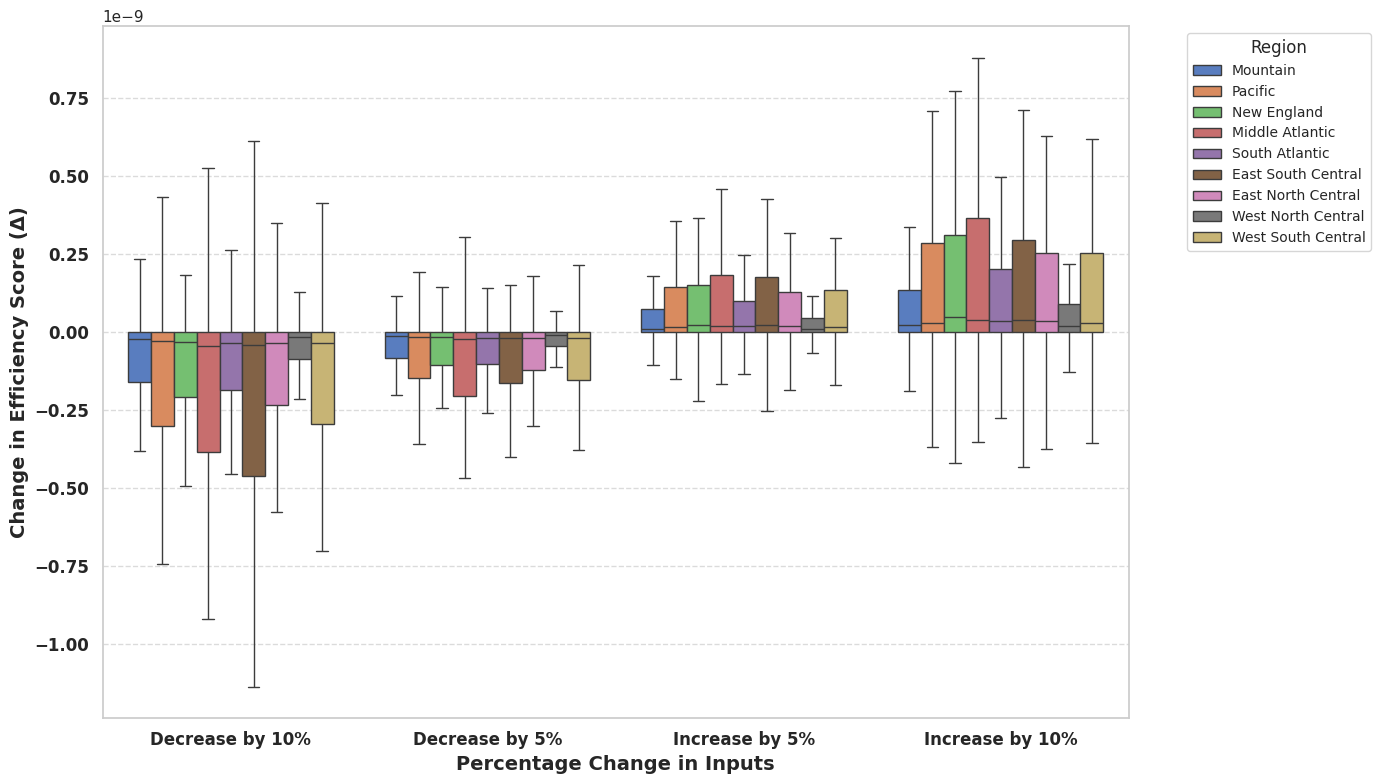

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def dea_sensitivity_analysis(panel_dea_function, df, inputs_columns, outputs_columns, perturbations):
    # Run the DEA analysis on the original data
    original_efficiency_df = panel_dea_function(df, inputs_columns, outputs_columns)
    original_efficiency_df = original_efficiency_df[['SubRecipientCode', 'Year', 'Efficiency Score', 'Region']]

    # Initialize a DataFrame to store the changes in efficiency scores
    sensitivity_results = original_efficiency_df.copy()
    sensitivity_results = sensitivity_results[['SubRecipientCode', 'Year', 'Region']]

    for perturbation in perturbations:
        # Perturb inputs by increasing/decreasing them by a percentage
        df_perturbed = df.copy()
        df_perturbed[inputs_columns] = df_perturbed[inputs_columns] * (1 + perturbation)

        # Recalculate efficiency scores after perturbation
        perturbed_efficiency_df = panel_dea_function(df_perturbed, inputs_columns, outputs_columns)
        perturbed_efficiency_df = perturbed_efficiency_df[['SubRecipientCode', 'Year', 'Efficiency Score']]

        # Merge the original and perturbed efficiency scores on SubRecipientCode and Year
        merged_df = original_efficiency_df.merge(perturbed_efficiency_df, on=['SubRecipientCode', 'Year'], suffixes=('_original', '_perturbed'))

        # Calculate the change in efficiency
        change_in_efficiency = merged_df['Efficiency Score_perturbed'] - merged_df['Efficiency Score_original']

        # Add the change to the sensitivity_results DataFrame
        sensitivity_results[f'Perturbation_{int(perturbation * 100)}%'] = change_in_efficiency

    return sensitivity_results

# Define the perturbations as percentages (±5%, ±10%)
perturbations = [-0.1, -0.05, 0.05, 0.1]

# Apply sensitivity analysis on df4
sensitivity_results = dea_sensitivity_analysis(panel_dea_analysis, df, inputs_columns, outputs_columns, perturbations)

# Melt the DataFrame for easier plotting
sensitivity_melted = sensitivity_results.melt(
    id_vars=['SubRecipientCode', 'Year', 'Region'],
    value_vars=[f'Perturbation_{int(p * 100)}%' for p in perturbations],
    var_name='Perturbation Level',
    value_name='Change in Efficiency'
)

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='Perturbation Level',
    y='Change in Efficiency',
    hue='Region',
    data=sensitivity_melted,
    showfliers=False
)

# Update x-axis tick labels
plt.xticks(
    ticks=range(len(perturbations)),
    labels=[
        'Decrease by 10%',
        'Decrease by 5%',
        'Increase by 5%',
        'Increase by 10%'
    ],
    fontsize=12,
    fontweight='bold'
)

# Bold y-axis numbers and labels
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel('Change in Efficiency Score (Δ)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage Change in Inputs', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Clustering Analysis**

In [8]:
combined=panel_dea_results_sorted

In [9]:
# Renaming the Score columns in both dataframes.
combined.rename(columns={"Efficiency Score": "combined_score"}, inplace=True)

combined


,SubRecipientCode,Year,combined_score,State,Region
0,0R01-00311,2018,1.000000,ID,Mountain
1,0R01-00311,2019,1.000000,ID,Mountain
2,0R01-00311,2020,0.919361,ID,Mountain
3,0R01-00311,2021,0.845443,ID,Mountain
4,0R01-00311,2022,1.000000,ID,Mountain
...,...,...,...,...,...
5270,9R06-99434,2018,1.000000,AS,Pacific
5271,9R06-99434,2019,1.000000,AS,Pacific
5272,9R06-99434,2020,1.000000,AS,Pacific
5273,9R06-99434,2021,0.957792,AS,Pacific


In [10]:

# Define the path to the uploaded file
file_path = '/content/drive/MyDrive/WVUResearch/efficiency-Effectiveness_data.csv'
df = pd.read_csv(file_path)
# Merging the two dataframes on the common columns.
combined_df = pd.merge(df, combined, on=["SubRecipientCode", "Year", "State", "Region"])
combined_df

,SubRecipientCode,Year,Efficiency_score,State,Region,Effectiveness_score,combined_score
0,0R01-00311,2018,1.000000,ID,Mountain,1.000000,1.000000
1,0R01-00311,2019,1.000000,ID,Mountain,1.000000,1.000000
2,0R01-00311,2020,0.919361,ID,Mountain,0.919361,0.919361
3,0R01-00311,2021,0.845443,ID,Mountain,0.845443,0.845443
4,0R01-00311,2022,1.000000,ID,Mountain,0.777778,1.000000
...,...,...,...,...,...,...,...
5270,9R06-99434,2018,1.000000,AS,Pacific,1.000000,1.000000
5271,9R06-99434,2019,1.000000,AS,Pacific,1.000000,1.000000
5272,9R06-99434,2020,1.000000,AS,Pacific,1.000000,1.000000
5273,9R06-99434,2021,0.957792,AS,Pacific,0.913309,0.957792


In [11]:
combined_df.to_csv('/content/drive/MyDrive/WVUResearch/Efficiency-Effectiveness_Cobined-Scores-data.csv', index=False)

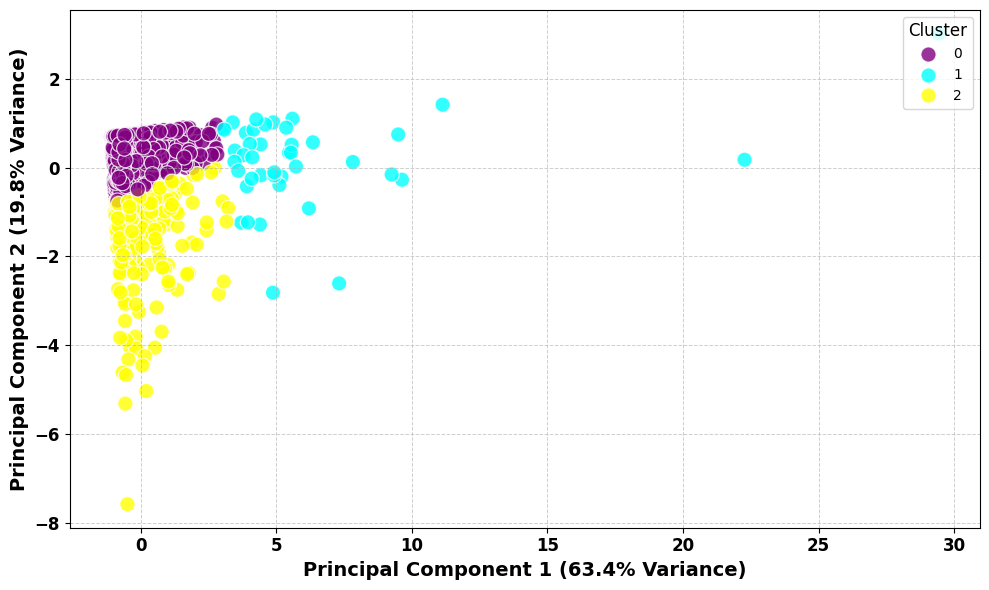

In [6]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Merge panel_dea_results_sorted with df4 on SubRecipientCode and Year
merged_df = pd.merge(panel_dea_results_sorted, df, on=['SubRecipientCode', 'Year'])

# Step 1: Aggregating the data across years for each agency
# We're assuming 'merged_df' contains all the necessary columns, including the yearly data for each agency.
aggregated_data = merged_df.groupby('SubRecipientCode').agg({
    'Total Operating Expense': 'mean',  # Average of operating expense across years
    'Total Active Revenue Vehicles': 'mean',  # Average of active vehicles
    'Annual Vehicle Revenue Miles': 'mean',  # Average of vehicle revenue miles
    'Total Unlinked Passenger Trips': 'mean',  # Average of passenger trips
    'Efficiency Score': 'mean'  # Average of efficiency score
}).reset_index()

# Assuming 'aggregated_data' is your DataFrame with the aggregated variables and 'Cluster' labels

# Step 1: Select features and standardize the data
features = ['Total Operating Expense', 'Total Active Revenue Vehicles',
            'Annual Vehicle Revenue Miles', 'Total Unlinked Passenger Trips', 'Efficiency Score']
X = aggregated_data[features]

# Standardizing the features
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Step 1: Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(X_scaled)

# Step 2: Add the cluster labels to the aggregated_data DataFrame
aggregated_data['Cluster'] = clusters

# Step 3: Perform PCA and create the final DataFrame
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

finalDf = pd.concat([principalDf, aggregated_data[['Cluster']]], axis=1)

# Step 4: Visualize the clusters on the PCA plot
plt.figure(figsize=(10, 6))

# Define custom palette
palette = {0: 'purple', 1: 'cyan', 2: 'yellow'}

# Scatter plot
sns.scatterplot(data=finalDf, x='PC1', y='PC2', hue='Cluster', palette=palette, s=120, alpha=0.8)

# Axes labels with bold formatting
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)', fontsize=14, fontweight='bold')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)', fontsize=14, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Title
# plt.title('PCA-Based Clustering of Transit Agency Efficiency', fontsize=16, fontweight='bold')

# Legend adjustments
plt.legend(title='Cluster', loc='upper right', fontsize=10, title_fontsize=12, frameon=True)

# Gridlines
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Tight layout
plt.tight_layout()

plt.show()